![title](images/logo_datacraft.png)

<h1><center>Ethical AI</center></h1>
<center><i>Datacraft workshop, sponsored by La French Tech</i></center>


**Objective of the notebook**: understand how to tackle the fairness challenge in AI on real use case - credit granting

This exercise highly relies on the work conducted by the Dalex team (see [here](https://dalex.drwhy.ai/), [here](https://dalex.drwhy.ai/python-dalex-fairness.html) or [here](https://dalex.drwhy.ai/python-dalex-fairness2.html)). It is based on the German Credit dataset. This dataset is often used to benchmark fairness approaches.

Our humble ambition is to combine the power of different tools: Dalex as a base, complemented by other tools from the open source community, like [AIF360](https://aif360.mybluemix.net/).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prerequesites" data-toc-modified-id="Prerequesites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prerequesites</a></span></li><li><span><a href="#Bias-a-priori" data-toc-modified-id="Bias-a-priori-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bias a priori</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#ML-prerequisites" data-toc-modified-id="ML-prerequisites-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ML prerequisites</a></span></li><li><span><a href="#Fairness-evaluation-principles" data-toc-modified-id="Fairness-evaluation-principles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fairness evaluation principles</a></span></li><li><span><a href="#Strategies" data-toc-modified-id="Strategies-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Strategies</a></span><ul class="toc-item"><li><span><a href="#Do-nothing" data-toc-modified-id="Do-nothing-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Do nothing</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Algorithmic-performance" data-toc-modified-id="Algorithmic-performance-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Algorithmic performance</a></span></li><li><span><a href="#Fairness-performance" data-toc-modified-id="Fairness-performance-7.1.3"><span class="toc-item-num">7.1.3&nbsp;&nbsp;</span>Fairness performance</a></span></li></ul></li><li><span><a href="#Remove-sensitive-attribute" data-toc-modified-id="Remove-sensitive-attribute-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Remove sensitive attribute</a></span></li><li><span><a href="#Adversarial-inprocessing" data-toc-modified-id="Adversarial-inprocessing-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Adversarial inprocessing</a></span></li><li><span><a href="#Calibrate-equalized-ODTS" data-toc-modified-id="Calibrate-equalized-ODTS-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Calibrate equalized ODTS</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Comparison</a></span></li></ul></li></ul></div>

## Prerequesites

In [1]:
# We strongly recommend to install the necessary libraries from a dedicated virtual environment
# See Minicoda e.g.: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands

# ! pip install fairlearn
# ! pip install dalex -U
# ! pip install -U scikit-learn
# ! pip install -U pandas
# ! pip install aif360
# ! pip install -U plotly

In [2]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import aif360
import dalex as dx
import numpy as np
import pandas as pd
import sklearn

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

{
    "aif360": aif360.__version__,
    "dalex": dx.__version__,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": sklearn.__version__
}

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

{'aif360': '0.4.0',
 'dalex': '1.4.0',
 'numpy': '1.19.5',
 'pandas': '1.2.4',
 'sklearn': '1.0'}

In [3]:
sklearn.set_config(display="diagram")

## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (GDPR in Europe e.g.), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk to credit-seeker**.

Before implementing any AI system to predict the likelihood of a credit-seeker to be granted a credit, **AI engineers AND business stakeholders** should:
- Sit and identify potential sources of biases
- Define a one or several metrics that will quantify the bias of the AI system

---

In this case, potential biases might lie in:

- Genre
- Age
- Revenue?

## Dataset

In [4]:
df, target = dx.datasets.load_german(), "risk"

## EDA

In [5]:
def facets(df: pd.DataFrame):
    """ Displays Facets viz
    Source: https://colab.research.google.com/github/PAIR-code/facets/blob/master/colab_facets.ipynb#scrollTo=XtOzRy8Z3M36
    
    Parameters
    ----------
    df: pd.DataFrame
        Data to plot
    """
    from IPython.core.display import display, HTML
    jsonstr = df.to_json(orient='records')
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
            <facets-dive id="elem" height="600"></facets-dive>
            <script>
              var data = {jsonstr};
              document.querySelector("#elem").data = data;
            </script>"""
    html = HTML_TEMPLATE.format(jsonstr=jsonstr)
    display(HTML(html))

In [6]:
facets(df)

In [7]:
(
    df
    .groupby("sex")
    ["risk"]
    .value_counts(normalize=True)
    .multiply(100)
    .astype(int)
    .to_frame()
)

risk
sex    risk      
female 1       64
       0       35
male   1       72
       0       27

In [8]:
(
    df
    .assign(youth=lambda x: np.where(x["age"] <= 30, "young", "old"))
    .groupby("youth")
    ["risk"]
    .value_counts(normalize=True)
    .multiply(100)
    .astype(int)
    .to_frame()
)

risk
youth risk      
old   1       74
      0       25
young 1       63
      0       36

In [9]:
(
    df
    .assign(youth=lambda x: np.where(x["age"] <= 30, "young", "old"))
    .groupby(["sex", "youth"])
    ["risk"]
    .value_counts(normalize=True)
    .multiply(100)
    .astype(int)
    .to_frame()
)

risk
sex    youth risk      
female old   1       73
             0       26
       young 1       58
             0       41
male   old   1       74
             0       25
       young 1       68
             0       31

**Quick EDA**

If we bin by sex, we realize that women are:
- Under represented in volume (310 vs 690)
- Slightly biased from a credit-granting perspective (64% vs 72%)

If we bin by age, we realize that young are:
- Under represented in volume (411 VS 589)
- Slightly biased from a credit-granting perspective (63% vs 74%)

If we combine the two, biases in input data are amplified.

**Conclusion: the apriori from section 2 looks confirmed and will need to be carefully handled during modelling.**

----

**Notes**

1. This is a toy example where biases are "straightforward" and well identified as "recurrent" social biases. However, it might not always be as easy to detect them. Additional sources might come from data history, selection bias, data incompleteness, unexpected sources of bias (column/attribute), ...
2. In this example, we identified biases related to representation in volume. If we had not been exposed to such discrepencies, namely having a balanced dataset, could we have concluded that biases would have been limited while modelling? Not so sure, see [this article](https://arxiv.org/pdf/1811.08489.pdf).

## ML prerequisites

In [27]:
df["job"] = df["job"].astype("object")
df["sex"] = np.where(df["sex"] == "female", 1, 0).astype(np.int64)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[target]),
    df[target],
    test_size=0.3,
    random_state=42
)

## Fairness evaluation principles

![title](images/dalex_pipeline.jpg)

The main object of dalex is the `Explainer` container which wraps a **dataset** (features and target) and a **trained model**. 

Once the data and the model have been wrapped, one needs to fix **protected and privileged attributes**.

**Important note**: beware these choices correspond to an a priori understanding of the problem and could miss hidden flaws of the model. An interesting line of work would consist in conducting a kind of grid-search exploration for potential biases.

In [29]:
# protected = df.sex.astype("str") + '_' + np.where(df.age < 25, 'young', 'old')
protected = X_test.sex.astype("str") + '_' + np.where(X_test.age < 25, 'young', 'old')
privileged = '0_old'

## Strategies

Following section intends to implement different strategies to mitigate the bias:
- No strategy implemented
- Pre-processing strategy: edit the data priori to fitting a model
- In-processing: change the way a model is trained, changing the loss function e.g.
- Post-processing: edit the predictions once a model has been fitted
- (Business-rule: implement a business that is intended to manually mitigate the bias, see this [article](https://towardsdatascience.com/tutorial-breaking-myths-about-ai-fairness-the-case-of-biased-automated-recruitment-9ee9b2ecc3a))

### Do nothing

#### Training

In [30]:
preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

clf_decisiontree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
])

In [31]:
# clf_decisiontree.fit(df.drop(columns=[target]), df[target])
clf_decisiontree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fada2bf1280>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fada2bf1fa0>)])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=7, random_state=123))])

In [32]:
# exp_decisiontree = dx.Explainer(clf_decisiontree, df.drop(columns=[target]), df[target], verbose=False)
exp_decisiontree = dx.Explainer(clf_decisiontree, X_test, y_test, verbose=True)

Preparation of a new explainer is initiated

  -> data              : 300 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 300 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fad61519670> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.711, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.0138, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


#### Algorithmic performance

In [33]:
exp_decisiontree.model_performance().result

,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.822967,0.751092,0.785388,0.686667,0.67004


#### Fairness performance

Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.

In [34]:
fairness_decisiontree = exp_decisiontree.model_fairness(protected=protected, privileged=privileged)

In [35]:
fairness_decisiontree.fairness_check(epsilon = 0.8) # default epsilon

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
              TPR       ACC       PPV       FPR       STP
0_young  0.567537  0.812676  0.964191  0.417827  0.506587


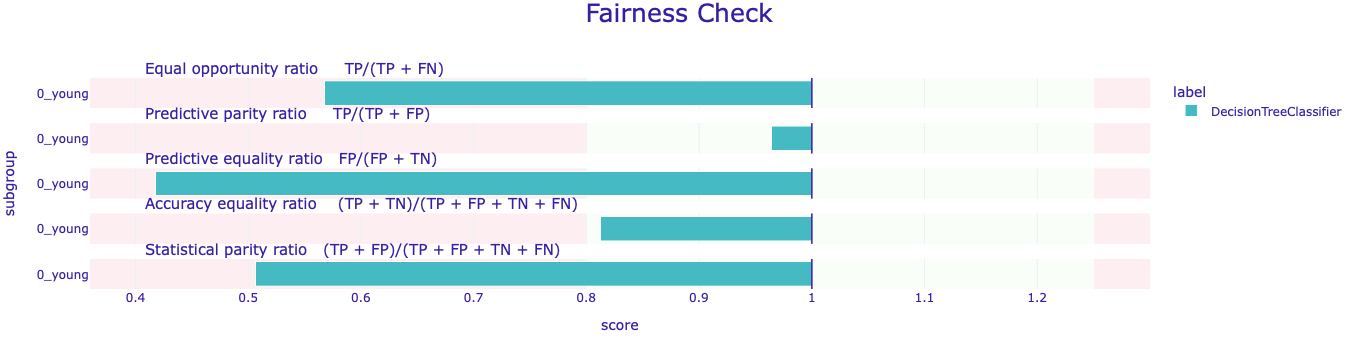

In [36]:
fairness_decisiontree.plot()

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

### Remove sensitive attribute

### Adversarial inprocessing

The adversarial inprocessing method consists in learning a target attribute $y$ (here the risk) while forgetting a fixed sensitive attribute $s$. This is done by learning a neural network and minimizing a loss of the form:
$$ \mathcal{L} = \mathcal{L}_{CE}(y,\hat{y}) - \lambda \mathcal{L}_{CE}(s,\hat{s}), $$
where $\lambda$ controls the fairness-accuracy tradeoff. 

This method is implemented in aif360 in the case of a binary sensitive attribute. In the following we incorporate it into the dalex pipeline.

In [60]:
from aif360.sklearn.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
sess = tf.Session()
tf.disable_eager_execution()
tf.random.set_random_seed(42)

In [61]:
df_in, target_in = dx.datasets.load_german(), "risk"
df_in["job"] = df_in["job"].astype("object")
df_in["sex"] = np.where(df_in["sex"] == "female", 1, 0).astype(np.int64)
df_in["youth"] = np.where(df_in.age <= 25, 1, 0).astype(np.int64)
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(
    df_in.drop(columns=[target_in]),
    df_in[target_in],
    test_size=0.3,
    random_state=42
)

preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object)),
)

X_prep_train =  preprocessor.fit_transform(X_train)
columns_names = preprocessor.get_feature_names_out(preprocessor.feature_names_in_)

protected = np.where(X_test.age <= 25, 'young', 'old')  # X_test.sex.astype("str") 
privileged = 'old'

class ToFrame():
    def __init__(self):
        pass
        #print('ok')
    
    def fit(self, arr, y=None):
        return self
    
    def transform(self, arr, y=None):
        df = pd.DataFrame(arr)
        df.columns = columns_names
        df.index = df['passthrough__youth']
        #print(df.head())
        return df

In [62]:
models = []
for adv_weight in ['no_adv', 'adv']:
    if adv_weight == 'no_adv':
        models.append(
            
                        Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('toframe', ToFrame()),
                            ('classifier', DecisionTreeClassifier(max_depth=7, random_state=123))
                        ])       
                     )
    else:
        models.append(
                    Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('toframe', ToFrame()),
                        ('adv', AdversarialDebiasing(prot_attr='passthrough__youth', 
                                                     debias=True
                                                    ))
                            ])        
                 )

In [63]:
models_expl = []
for model in models:
    model.fit(X_train, y_train)
    models_expl.append(
                        dx.Explainer(model, X_test, y_test, verbose=False)
    )   

In [64]:
fobj = []
for i, expl in enumerate(models_expl):
    fobj.append(
                expl.model_fairness(protected=protected, privileged=privileged)
    )
    fobj[-1].label ='adv_{}'.format(i)

In [65]:
fobj[0].fairness_check()

Bias detected in 4 metrics: TPR, ACC, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
        TPR       ACC      PPV       FPR       STP
young  0.57  0.786908  0.94695  0.473469  0.529894


In [66]:
fobj[1].fairness_check()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
       TPR       ACC       PPV  FPR  STP
young  1.0  0.880952  0.880952  1.0  1.0


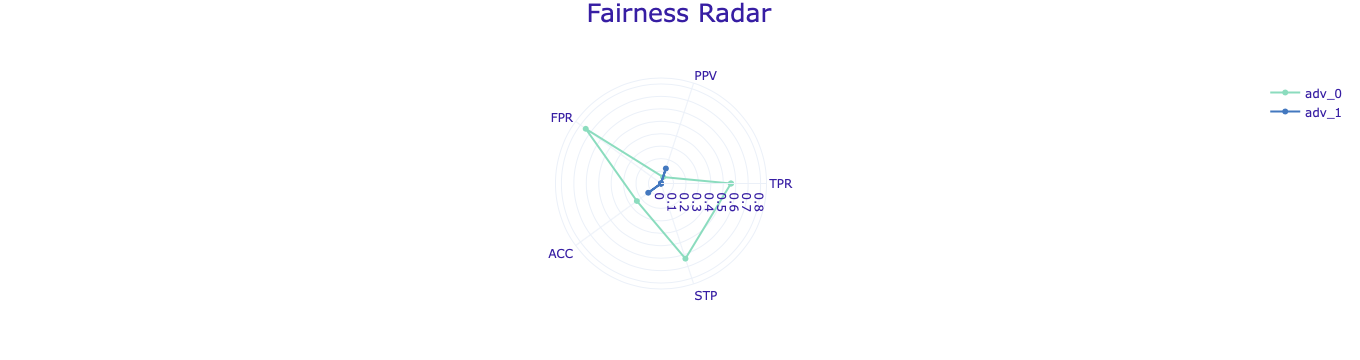

In [67]:
fobj[0].plot(objects=[fobj[1]], type = "radar")

### Calibrate equalized ODTS

### Comparison

In [ ]:
fairness_decisiontree.plot(objects=[fairness_sensitive, fairness_adversarial, fairness_odts])

In [ ]:
fairness_decisiontree.plot(objects=[fairness_sensitive, fairness_adversarial, fairness_odts], type = "heatmap")

In [ ]:
fairness_decisiontree.plot(objects=[fairness_sensitive, fairness_adversarial, fairness_odts], type = "stacked")

In [ ]:
fairness_decisiontree.plot(objects=[fairness_sensitive, fairness_adversarial, fairness_odts], type = "performance_and_fairness")

In [ ]:
fairness_decisiontree.plot(objects=[fairness_sensitive, fairness_adversarial, fairness_odts], type = "ceteris_paribus_cutoff", subgroup="female_young")